In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
dfs0 = pd.read_csv('Data/Solar Data/Solar 0.csv')

In [3]:
dfs0

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,0,0.00,2020-04-25 14:00:00,2020,4,25,14,0,Solar0
1,4,0.00,2020-04-25 15:00:00,2020,4,25,15,0,Solar0
2,8,0.00,2020-04-25 16:00:00,2020,4,25,16,0,Solar0
3,12,0.00,2020-04-25 17:00:00,2020,4,25,17,0,Solar0
4,16,0.00,2020-04-25 18:00:00,2020,4,25,18,0,Solar0
...,...,...,...,...,...,...,...,...,...
4541,18164,0.01,2020-10-31 19:00:00,2020,10,31,19,0,Solar0
4542,18168,1.45,2020-10-31 20:00:00,2020,10,31,20,0,Solar0
4543,18172,4.69,2020-10-31 21:00:00,2020,10,31,21,0,Solar0
4544,18176,8.73,2020-10-31 22:00:00,2020,10,31,22,0,Solar0


In [6]:
data = dfs0['series_value'][3000:3500]

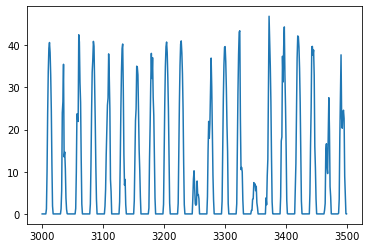

In [7]:
plt.plot(data)

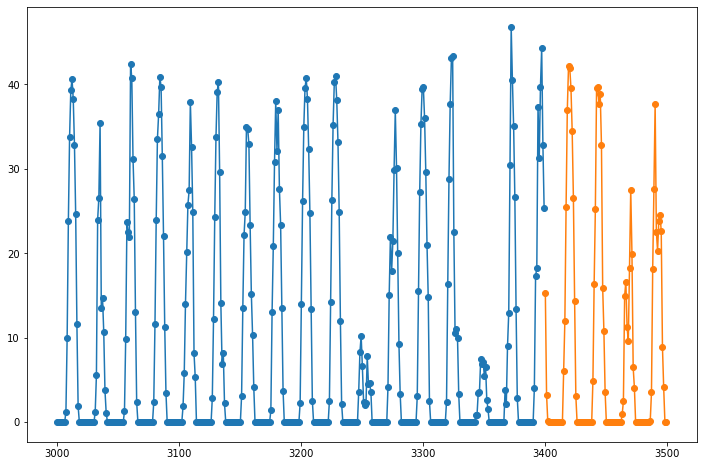

In [8]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [9]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1144.899
Date:                Tue, 27 Sep 2022   AIC                           2299.798
Time:                        23:33:58   BIC                           2319.756
Sample:                             0   HQIC                          2307.702
                                - 400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0708      0.269      3.987      0.000       0.544       1.597
ar.L1          1.6933      0.043     39.037      0.000       1.608       1.778
ar.L2         -0.8143      0.043    -19.120      0.000      -0.898      -0.731
ma.L1         -0.3761      0.065     -5.791      0.000      -0.503      -0.249
sigma2        17.8026      0.822     21.649      0.000      16.191      19.414
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               610.06
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.70
Prob(H) (two-sided):                  0.87   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
data = train
# define model
my_order = (2, 1, 1)
my_seasonal_order = (2, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

C:\Users\sohan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sohan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
yhat

3000    0.000000
3001    0.010000
3002    0.010000
3003    0.010000
3004    0.010000
          ...   
3096    0.183249
3097    0.133988
3098    0.136721
3099    0.132045
3100    0.127705
Name: predicted_mean, Length: 101, dtype: float64

In [39]:
lst = []
for i in range(3005, 3088):
    lst.append(yhat[i])

In [40]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [22]:
test

3400    15.27
3401     3.25
3402     0.09
3403     0.01
3404     0.01
        ...  
3495    22.62
3496     8.93
3497     4.13
3498     0.06
3499     0.01
Name: series_value, Length: 100, dtype: float64

In [36]:
lst = []
for i in range(3413, 3500):
    lst.append(test[i])

In [37]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

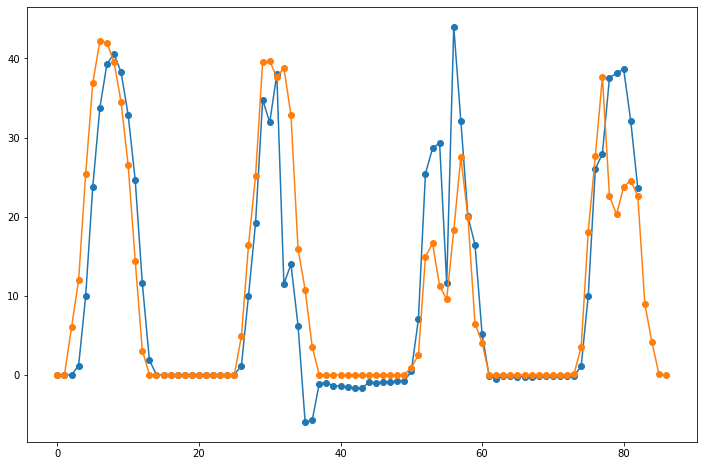

In [41]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [42]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

1.449739951902467